In [1]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from collections import Counter

# BoTorch / GPyTorch 関連
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from mpl_toolkits.mplot3d import Axes3D  # 必要に応じて

# Plot周りの設定
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
plt.rcParams["figure.dpi"] = 100  # 高解像度設定

In [2]:
def styblinski_tang(x):
    """
    x: shape (..., d) のテンソル（d>=5を仮定）
       目的関数の計算には最初の5次元のみを利用する。
       ノイズは加えません。
    """
    # 最初の5次元を抽出
    if torch.is_tensor(x):
        x_val = x[..., :5]  # shape (..., 5)
    else:
        x_val = torch.tensor(x[..., :5], dtype=torch.float32)

    # 各次元ごとに Styblinski-Tang 関数を計算し、全次元で和を取る
    # f_i(x) = 0.5*(x_i^4 - 16x_i^2 + 5x_i)
    result = 0.5 * torch.sum(x_val ** 4 - 16 * x_val ** 2 + 5 * x_val, dim=-1)
    return result

In [3]:
class ECI_BO_Bandit:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, coordinate_ratio=0.5):
        """
        X: 初期サンプル点 (n_initial, dim)
        objective_function: 目的関数 (styblinski_tang など)
        bounds: 探索の下限・上限 (2, dim) のテンソル
        n_initial: 初期サンプル数
        n_max: 反復最大回数
        dim: 入力次元
        """
        dtype = torch.float
        self.num_arms = dim  # 各イテレーションで生成される候補方向の数

        # 線形バンディット用のパラメータ A, b の初期化
        self.A = torch.eye(dim, dtype=dtype)
        self.b = torch.zeros(dim, dtype=dtype)

        self.objective_function = objective_function
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []        # 各反復でのbest_valueの履歴
        self.arm_selection_history = []  # 選択された arm のインデックスの履歴
        self.optimization_history = []   # 探索した新しい点の履歴
        self.saved_plot_files = []       # GP後方分布のプロット保存用

        self.coordinate_ratio = coordinate_ratio

        # ★追加★: UCBおよび線形バンディットの解析用パラメータ
        # 【Abbasi‐Yadkori et al. (2012)】に基づく設定例
        self.sigma = 0.1         # ノイズ標準偏差の仮定
        self.L = 5.0             # 各アーム（特徴ベクトル）のノルム上限
        self.lambda_reg = 1.0    # 正則化パラメータ
        self.delta = 0.1         # 失敗確率
        self.S = 10.0            # 真のパラメータのノルム上限

        # ★追加★: 選択された方向（実際のベクトル）と推定θの履歴を記録
        self.selected_direction_history = []  # 各イテレーションで選ばれた方向のベクトル
        self.theta_history = []                 # 各イテレーションでの推定パラメータ theta

        self.reward_history = []   # 各イテレーションの更新量（報酬）を記録

        # ★変更★: 選択された方向の絶対値を累積（後で棒グラフで可視化）
        self.direction_sum_abs = torch.zeros(dim, dtype=dtype)

    def update_model(self):
        """
        BoTorchのSingleTaskGPを更新する。
        """
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-3).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        """
        初期点 X に対して目的関数を評価し、GPモデルを初期化する。
        ※ 修正点: GPの事後平均ではなく、実際の評価値の最小値を best_value とする。
        """
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)

        # GPモデル更新
        self.update_model()
        # 修正点：実際の評価値の最小値を用いる
        best_index = torch.argmin(self.Y.squeeze(-1))
        self.best_value = self.Y[best_index].item()
        self.best_point = self.X[best_index]

        self.eval_history = [self.best_value] * self.n_initial

    def generate_arms(self):
        """
        1イテレーションにつき合計 self.num_arms(=dim) 本の候補方向ベクトルを生成する関数。
        - うち (coordinate_ratio * dim) 本は座標方向ベクトル
        - うち 残りはランダム方向ベクトル
        - 結果を (num_arms, dim) の torch.Tensor で返す
        """
        dtype = torch.float
        num_coord = int(math.floor(self.coordinate_ratio * self.dim))
        if num_coord > self.dim:
            num_coord = self.dim

        # (1) 座標方向ベクトル
        random_indices = np.random.choice(self.dim, num_coord, replace=False)
        coordinate_arms = []
        for idx in random_indices:
            e_i = torch.zeros(self.dim, dtype=dtype)
            e_i[idx] = 1.0
            coordinate_arms.append(e_i)
        if len(coordinate_arms) > 0:
            coordinate_arms = torch.stack(coordinate_arms, dim=0)
        else:
            coordinate_arms = torch.zeros(0, self.dim, dtype=dtype)

        # (2) ランダム方向ベクトル
        num_random = self.dim - num_coord
        if num_random > 0:
            random_arms = torch.randn(num_random, self.dim, dtype=dtype)
            random_arms = random_arms / random_arms.norm(dim=1, keepdim=True)
        else:
            random_arms = torch.zeros(0, self.dim, dtype=dtype)

        arms = torch.cat([coordinate_arms, random_arms], dim=0)
        return arms

    def select_arm(self, total_iterations):
        """
        線形バンディット（LinUCBに基づく）により、候補方向の中から最良と思われる方向を選択する。
        UCB値は以下の形で計算する：
            UCB(x) = x^T * theta + beta_t * sqrt(x^T * A^{-1} * x)
        """
        A_inv = torch.inverse(self.A)
        theta = A_inv @ self.b
        self.theta_history.append(theta.clone())

        p_values = []
        beta_t = self.sigma * math.sqrt(self.dim * math.log((1 + total_iterations * (self.L ** 2) / self.lambda_reg) / self.delta)) \
                 + math.sqrt(self.lambda_reg) * self.S

        for i in range(self.num_arms):
            x_arm = self.arms_features[i].view(-1, 1)  # shape (dim,1)
            mean = (theta.view(1, -1) @ x_arm).item()
            var = (x_arm.t() @ A_inv @ x_arm).item()
            ucb = mean + beta_t * math.sqrt(var)
            p_values.append(ucb)

        return int(np.argmax(p_values))

    # ★ 新たにベイズ最適化部分を切り出したメソッド propose_new_x を追加
    def propose_new_x(self, direction):
        """
        GPモデルとEI (Expected Improvement) を用いて、現在の best_point から選択された方向 direction に沿った
        1次元の最適化を行い、bounds 内に収まる新たな評価点 new_x を返す関数です。

        戻り値:
            new_x: 新たに提案された評価点 (dim 次元のベクトル)
            candidate: optimize_acqf によって得られたスカラー候補 (torch.Tensor)
            acq_value: 対応するacquisition value
        """
        dtype = torch.float
        # EIの定義（現在の best_value を用いる）
        ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

        # 1次元最適化のための補助関数：best_point から direction に沿って t を変化させた点での EI を計算
        def eci_func(x):
            x_scalar = x.squeeze(-1).squeeze(-1)
            full_x = self.best_point.clone().unsqueeze(0) + x_scalar[:, None] * direction
            full_x = full_x.unsqueeze(1)
            return ei(full_x)

        # new_x = best_point + t * direction が各次元の bounds 内に収まるよう t の許容範囲を計算
        lower_list = []
        upper_list = []
        for i in range(self.dim):
            d_i = direction[i].item()
            if abs(d_i) < 1e-8:
                continue
            if d_i > 0:
                lower_list.append((self.bounds[0][i] - self.best_point[i]).item() / d_i)
                upper_list.append((self.bounds[1][i] - self.best_point[i]).item() / d_i)
            else:
                lower_list.append((self.bounds[1][i] - self.best_point[i]).item() / d_i)
                upper_list.append((self.bounds[0][i] - self.best_point[i]).item() / d_i)
        if lower_list:
            candidate_lower_bound = max(lower_list)
            candidate_upper_bound = min(upper_list)
        else:
            candidate_lower_bound = -5.0
            candidate_upper_bound = 5.0

        one_d_bounds = torch.tensor([[candidate_lower_bound], [candidate_upper_bound]], dtype=dtype)

        candidate, acq_value = optimize_acqf(
            eci_func,
            one_d_bounds,
            q=1,
            num_restarts=10,
            raw_samples=100,
        )

        new_x = self.best_point.clone() + candidate.squeeze() * direction
        return new_x, candidate, acq_value

    def optimize(self):
        """
        メインの最適化ループ。
        GPによる局所探索と線形バンディットによるグローバル探索（方向選択）を組み合わせる。
        """
        self.initialize()
        self.optimization_history = []
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float
        self.update_model()

        while n < self.n_max:
            self.arms_features = self.generate_arms()

            # 線形バンディットで候補方向を選択
            selected_arm = self.select_arm(total_iterations)
            self.arm_selection_history.append(selected_arm)
            direction = self.arms_features[selected_arm]
            self.selected_direction_history.append(direction.clone())

            # ★ ベイズ最適化部分を propose_new_x メソッドで実行し new_x を獲得する
            new_x, candidate, acq_value = self.propose_new_x(direction)

            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)

            # データの更新
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.optimization_history.append(new_x.clone())

            # 線形バンディットの情報更新：Aは方向ベクトルの外積で更新
            x_arm = direction.view(-1, 1)
            self.A = self.A + x_arm @ x_arm.t()

            # 現在の GP モデルを用いて new_x における事後平均を計算（p とする）
            p = self.model.posterior(new_x.unsqueeze(0)).mean.squeeze()
            # 報酬を exp(-||p - new_y||) で定義（ここでは p, new_y はスカラーと仮定）
            reward = 10 * (1 + -1 * torch.exp(-torch.abs(p - new_y.squeeze())).item())
            self.reward_history.append(reward)
            self.b = self.b + reward * direction

            # GPモデルの更新と、これまでの評価点の最小値を best_value として更新
            self.update_model()
            best_index = torch.argmin(self.Y.squeeze(-1))
            self.best_value = self.Y[best_index].item()
            self.best_point = self.X[best_index]

            self.eval_history.append(self.best_value)
            self.direction_sum_abs += direction.abs()

            n += 1
            total_iterations += 1

        return self.best_point, self.best_value


In [4]:
def generate_initial_points(n_initial, dim, bounds):
    """
    指定した範囲 bounds の中で一様乱数を用いて初期点を生成する関数。
    bounds: shape (2, dim) のテンソルで、下限と上限が与えられる。
    """
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

In [5]:
if __name__ == "__main__":
    # パラメータ設定
    dim = 50  # 100次元実験
    # 各次元の下限は -5, 上限は 5 とする（100次元分のベクトル）
    bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
    n_initial = 10   # 初期サンプル数
    n_iter = 500     # BOイテレーション数
    n_runs = 200      # 複数試行回数

    # 実験
    eci_bo_bandit_history = []
    arm_selection_history = []
    bandit_list = []

    try:
        with tqdm.notebook.tqdm(total=n_runs, bar_format=TQDM_BAR_FORMAT) as pbar:
            with io.capture_output() as captured:
                for run in range(n_runs):
                    X_init = generate_initial_points(n_initial, dim, bounds)
                    # ECI_BO_Bandit インスタンス生成
                    eci_bo_bandit = ECI_BO_Bandit(
                        X_init,
                        objective_function=styblinski_tang,  # styblinski_tang 関数を目的関数に
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim,
                        coordinate_ratio=0.9
                    )
                    best_x, best_f = eci_bo_bandit.optimize()

                    # 各試行の評価履歴を保存
                    eci_bo_bandit_history.append(eci_bo_bandit.eval_history)
                    arm_selection_history.append(eci_bo_bandit.arm_selection_history)
                    bandit_list.append(eci_bo_bandit)

                    pbar.update(1)
    except subprocess.CalledProcessError:
        print(captured)
        raise

  0%|          | 0/200 [elapsed: 00:00 remaining: ?]

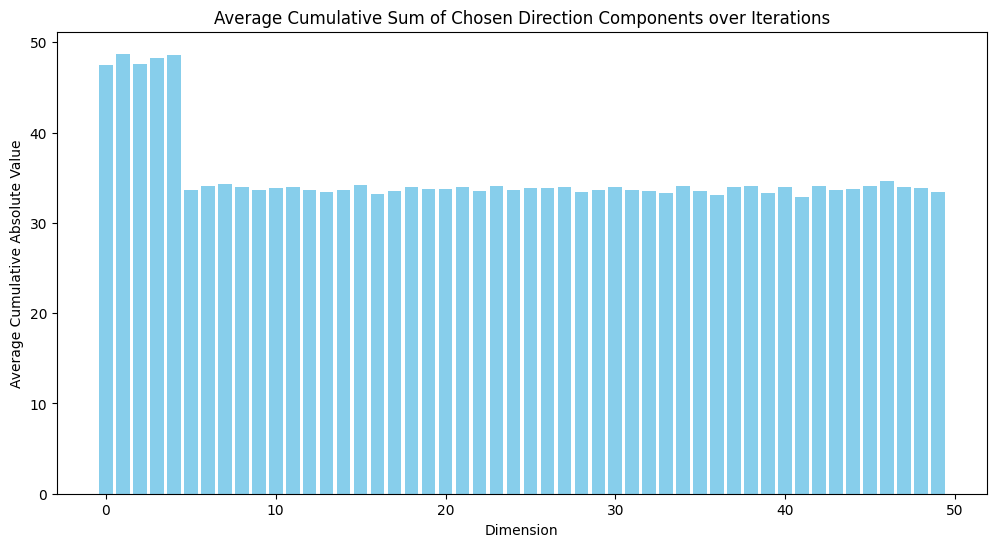

In [6]:
# 3. すべての試行における選択された方向の各次元の累積和の平均を棒グラフで表示
all_direction_sums_abs = np.array([bandit.direction_sum_abs.cpu().numpy() for bandit in bandit_list])
avg_direction_sums_abs = all_direction_sums_abs.mean(axis=0)
plt.figure(figsize=(12, 6))
plt.bar(np.arange(dim), avg_direction_sums_abs, color='skyblue')
plt.xlabel("Dimension")
plt.ylabel("Average Cumulative Absolute Value")
plt.title("Average Cumulative Sum of Chosen Direction Components over Iterations")
plt.show()

In [7]:
selected_dir_history = [dir.cpu().numpy() for dir in bandit_list[0].selected_direction_history]
selected_dir_df = pd.DataFrame(selected_dir_history)
selected_dir_df['reward'] = bandit_list[0].reward_history
selected_dir_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,reward
0,0.043319,0.234231,0.156931,-0.182276,-0.029828,0.229912,-0.176928,0.033552,0.108337,-0.181807,...,-0.219058,0.126477,0.004755,0.130468,0.290278,-0.038986,-0.065341,0.022121,0.055798,9.999994
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.725584
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.305605
3,-0.159786,0.107182,0.173392,-0.094207,-0.077575,0.174761,-0.197835,0.162012,0.063976,0.109991,...,-0.110024,0.018856,-0.092251,-0.067993,0.103266,-0.021663,-0.098400,0.031797,0.053089,3.876340
4,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.572242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.377516
486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.997446
487,-0.080605,-0.088733,-0.073883,0.127473,0.022718,0.081907,-0.013077,0.040368,-0.056433,0.010457,...,-0.028469,0.159862,0.066815,-0.188965,0.105127,-0.104271,0.017479,0.154167,-0.187107,9.997689
488,0.178761,0.046376,0.087225,0.148844,0.338641,0.076503,0.020165,-0.019704,0.083871,0.133697,...,-0.117055,-0.063250,0.102735,-0.290410,-0.004778,0.049608,0.130260,-0.147232,0.095492,1.439757


In [8]:
theta_history = [theta.cpu().numpy() for theta in bandit_list[0].theta_history]
theta_df = pd.DataFrame(theta_history)
print(theta_df.shape)
theta_df

(490, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.216597,1.171154,0.784655,-0.911379,-0.149141,1.149557,-0.884639,0.167762,0.541685,-0.909033,...,0.137767,-1.095287,0.632384,0.023776,0.652342,1.451387,-0.194931,-0.326705,0.110606,0.278992
2,0.206082,1.114302,0.746566,-0.867136,-0.141901,1.093753,-0.841695,0.159618,0.515389,-0.864905,...,0.131079,-1.042117,0.601685,0.022622,0.620675,3.053258,-0.185469,-0.310845,0.105237,0.265449
3,0.197616,1.068523,0.715894,-0.831512,-0.136071,1.048818,-0.807116,0.153061,0.494215,-0.829372,...,0.125694,-0.999304,0.576966,0.021693,0.595175,3.024891,-0.177849,-0.298075,0.100914,0.254543
4,-0.002870,1.161159,0.901037,-0.916684,-0.225322,1.224020,-1.018696,0.344026,0.554511,-0.667207,...,0.440582,-1.097793,0.579710,-0.090836,0.492057,3.064383,-0.197899,-0.406914,0.135924,0.309999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,-0.136433,6.001235,-4.045120,5.722756,3.385861,4.095713,3.085181,0.368376,3.760296,0.262422,...,1.172772,0.052082,-1.120416,4.507375,-2.927203,1.197643,0.887084,-0.128582,-1.130439,4.604077
486,-0.125186,6.002937,-4.015147,5.721333,3.389698,4.103857,3.085797,0.374353,3.759322,0.245688,...,1.171986,0.046945,-1.135380,4.515932,-2.910239,1.221120,0.904065,-0.138645,-1.131766,4.241234
487,-0.139292,6.000804,-4.052741,5.723115,3.384888,4.093644,3.085026,0.366857,3.760543,0.266678,...,1.172972,0.053388,-1.116612,4.505198,-2.931517,1.191674,0.882767,-0.126023,-1.130101,4.696327
488,-0.213767,5.987072,-4.155791,5.734515,3.395710,4.132017,3.051444,0.390060,3.740164,0.295156,...,1.108866,0.067325,-0.882820,4.507295,-3.089384,1.255503,0.778549,-0.097809,-1.055887,4.651141


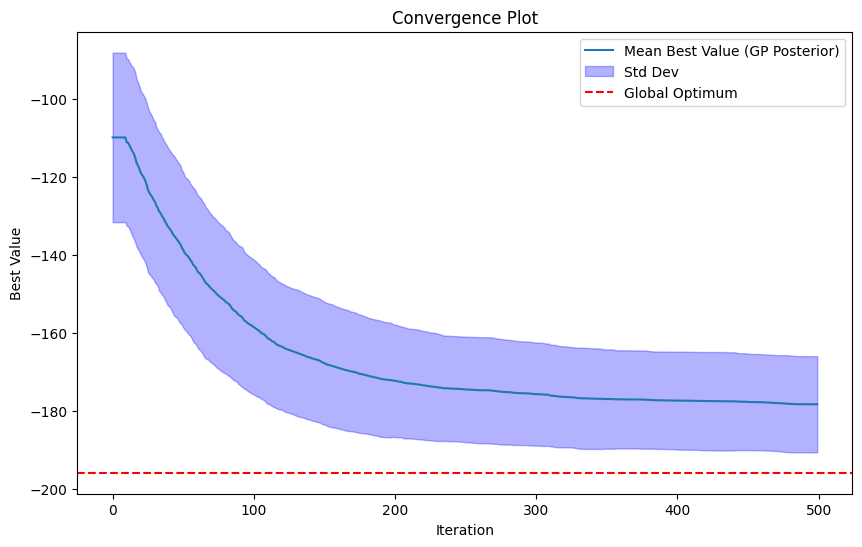

In [9]:
global_optimum = -39.16599 * 5  # 5次元の場合の最適値

# すべての試行におけるベスト値の履歴（リストのリスト）
all_histories = np.array(eci_bo_bandit_history)  # shape: (n_runs, num_iterations)
mean_history = all_histories.mean(axis=0)
std_history = all_histories.std(axis=0)
iterations = np.arange(len(mean_history))

plt.figure(figsize=(10,6))
plt.plot(iterations, mean_history, label="Mean Best Value (GP Posterior)")
plt.fill_between(iterations, mean_history - std_history, mean_history + std_history,
                 color='blue', alpha=0.3, label="Std Dev")
plt.axhline(y=global_optimum, color='r', linestyle='--', label="Global Optimum")
plt.xlabel("Iteration")
plt.ylabel("Best Value")
plt.title("Convergence Plot")
plt.legend()
plt.show()

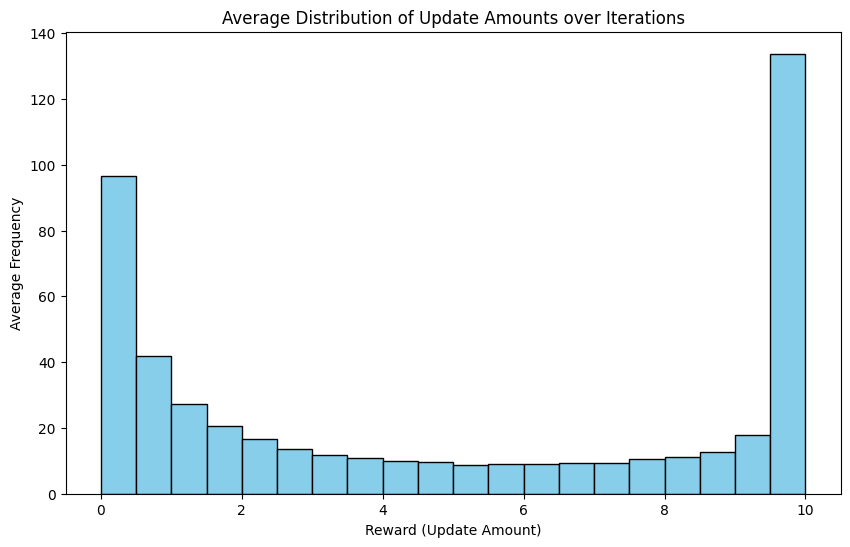

In [10]:
# (6) Distribution of Update Amounts: 各試行ごとのヒストグラム頻度の平均を表示（横軸：Reward, 縦軸：Average Frequency）
num_bins = 20
# 各試行のreward_history（numpy配列）のリストを作成
all_rewards_runs = [np.array(bandit.reward_history) for bandit in bandit_list]
# すべての試行のrewardをまとめ、共通のbinsを決定（最小値と最大値から）
all_rewards_concatenated = np.concatenate(all_rewards_runs)
bins = np.linspace(all_rewards_concatenated.min(), all_rewards_concatenated.max(), num_bins+1)

# 各試行について、binsに沿ったヒストグラムの頻度を計算
all_counts = []
for rewards in all_rewards_runs:
    counts, _ = np.histogram(rewards, bins=bins)
    all_counts.append(counts)
all_counts = np.array(all_counts)  # shape: (n_runs, num_bins)
# 各ビンごとに平均頻度を計算
avg_counts = all_counts.mean(axis=0)
# ビンの中心を求める
bin_centers = 0.5*(bins[1:] + bins[:-1])

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, avg_counts, width=bin_centers[1]-bin_centers[0], color='skyblue', edgecolor='black')
plt.xlabel("Reward (Update Amount)")
plt.ylabel("Average Frequency")
plt.title("Average Distribution of Update Amounts over Iterations")
plt.show()